In [1]:
# import the necessary packages
import numpy as np
import tensorflow as tf
import pandas as pd
import math
from random import shuffle
import os
import sox
import librosa
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
import itertools

2022-12-01 13:03:25.452632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 13:03:25.587410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 13:03:25.587433: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-01 13:03:26.364512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
# defining some constants
input_dim = 20000
num_classes = 10
alpha = 0.00001
num_epochs = 200
batch_size = 512
classificationweight = 0.0001

In [3]:
# plots the confusion matrix for the given predictions and labels (taken from scikit-learn.org)
def plot_confusion_matrix(cm, classes,
						  normalize=False,
						  title='Confusion matrix',
						  cmap=plt.cm.Blues):
	if normalize:
		cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
		print("Normalized confusion matrix")
	else:
		print('Confusion matrix, without normalization')

	print(cm)

	plt.imshow(cm, interpolation='nearest', cmap=cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	classes = ['classical', 'country', 'metal', 'pop']

	plt.xticks(tick_marks, classes, rotation=45)
	plt.yticks(tick_marks, classes)

	fmt = '.2f' if normalize else 'd'
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, format(cm[i, j], fmt),
				 horizontalalignment="center",
				 color="white" if cm[i, j] > thresh else "black")
	plt.tight_layout()
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.show()

In [4]:
# runs PCA on the given data and returns the transformed data and the PCA object (for later use) 
def runPCA2D(sess, encoding, inputs_batch, labels_batch, X, Y, y_hat):
	# initialize the PCA object with 2 components (2D)
	allgenres = ['classical', 'country', 'metal', 'pop']
	fig = plt.figure(1, figsize=(4, 3))
	plt.clf()
	ax = plt.axes()
	plt.cla()

	# run PCA on the data
	truelabels = tf.math.argmax(input=Y, axis=1).eval()
	pca = decomposition.PCA(n_components = 3)
	pca.fit(X)
	latents = pca.transform(X)
	colors = [('purple', 'Pop', 3), ('darkorange', 'Metal', 2), ('green', 'country', 1), ('navy', 'Classical', 0)]
	for color, name, label in colors:
		plt.scatter(latents[truelabels == label, 0], latents[truelabels == label, 1], color=color, alpha=.5,
                label=name, edgecolor='k')
	plt.title('PCA of 500-Dim Raw Audio Data')
	plt.legend(loc='upper right', shadow=False, scatterpoints=1)
	plt.show()

In [5]:
# tests the model on the test data and returns the accuracy and the confusion matrix for the predictions
def test(X, Y):
	with tf.compat.v1.Session() as sess:
		new_saver = tf.compat.v1.train.import_meta_graph('./modelWeights/softmaxautoencoder-200.meta')
		new_saver.restore(sess, tf.train.latest_checkpoint('./modelWeights'))
		graph = tf.compat.v1.get_default_graph()
		inputs_batch = tf.compat.v1.get_collection('inputs_placeholder')[0]
		labels_batch = tf.compat.v1.get_collection('labels_placeholder')[0]
		encoding = tf.compat.v1.get_collection('encoding')[0]
		decoding = tf.compat.v1.get_collection('decoding')[0]
		y_hat = tf.compat.v1.get_collection('y_hat')[0]
		loss = tf.compat.v1.get_collection('loss')[0]
		_, preds = sess.run([encoding, y_hat], feed_dict={inputs_batch : X, labels_batch : Y})
		predictions = tf.math.argmax(input=preds, axis=1)
		truelabels = tf.math.argmax(input=Y, axis=1)
		numequal = tf.math.equal(predictions, truelabels)
		numcorrect = tf.math.count_nonzero(numequal)
		devaccuracy = numcorrect.eval() / float(X.shape[0])
		print("Dev Accuracy: " + str(devaccuracy))

		class_names = [0, 1, 2, 3]
		pred = predictions.eval()
		correct_labels = truelabels.eval()
		confmat = confusion_matrix(correct_labels, pred, labels=class_names)
		np.set_printoptions(precision=2)
		plt.figure()
		plot_confusion_matrix(confmat, classes=class_names, normalize=False, title='Confusion matrix, without normalization')
		plt.figure()

		# run PCA on the data
		runPCA2D(sess, encoding, inputs_batch, labels_batch, X, Y, y_hat)

2022-12-01 13:03:28.411238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 13:03:28.411549: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 13:03:28.411615: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-01 13:03:28.411743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-01 13:03:28.411846: W tensorflow/c

INFO:tensorflow:Restoring parameters from ./modelWeights/softmaxautoencoder-200


2022-12-01 13:03:31.738683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Dev Accuracy: 0.568
Confusion matrix, without normalization
[[454  42  16   2]
 [ 89 210 117  71]
 [ 30 138 211 123]
 [ 35 108  93 261]]


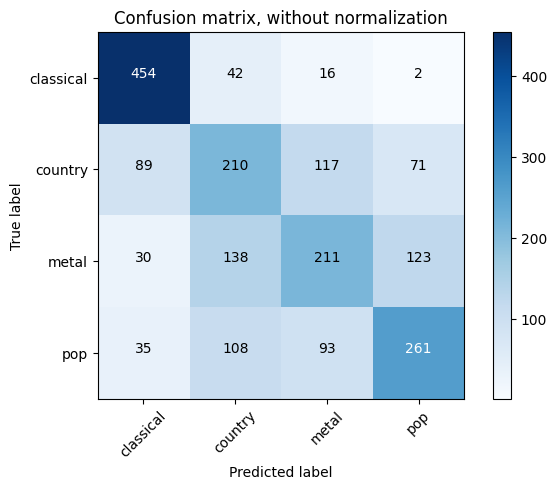

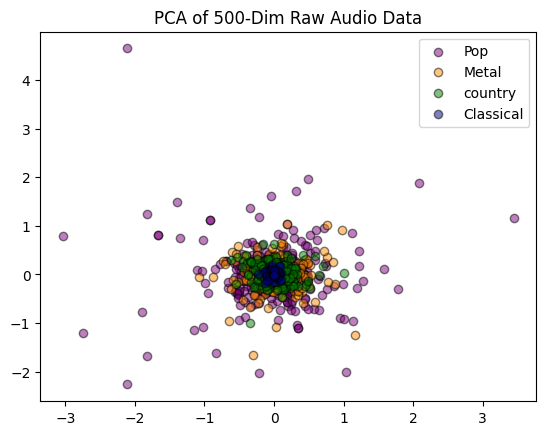

In [6]:
# loads the data from the given csv file and returns the data and labels as numpy arrays
songs = pd.read_csv('songs_dev.csv')
labels = pd.read_csv('labels_dev.csv')
test(songs, labels)